In [200]:
import warnings
warnings.filterwarnings('ignore')

In [201]:
import numpy as np
import pandas as pd

In [202]:
import math
import re
from collections import Counter

In [203]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.dpi'] = 125

### Loading results 

In [204]:
english_incidence_matrix = pd.read_csv('results/english_incidence_matrix.csv', index_col=0)
results_all = pd.read_csv('results/results.csv')
results_single_prob = pd.read_csv('results/results_single_prob.csv')

Adding distances from typical incidence matrix to results dataframes

In [205]:
def get_bigrams(text):
    return re.findall(r'(?=([a-zA-Z]{2}))', text)

def get_bigram_frequencies(text):
    bigrams = get_bigrams(text)
    counts = Counter(bigrams)
    df_counts = pd.DataFrame.from_dict(counts, orient='index').reset_index()
    df_counts = df_counts.rename(columns={'index':'bigram', 0:'frequency'})
    df_counts['first'] = df_counts.bigram.str[0]
    df_counts['second'] = df_counts.bigram.str[1]
    df_counts = df_counts.sort_values('bigram') 
    return df_counts

def create_template_matrix(text):
    index = sorted(list(set(text)))
    columns = index
    num_unique_letters = len(columns)
    data = np.zeros((num_unique_letters, num_unique_letters))
    template_matrix = pd.DataFrame(data, index=index, columns=columns)
    return template_matrix

def get_incidence_matrix(text):
    incidence_matrix = create_template_matrix(text)
    df_bigram_frequencies = get_bigram_frequencies(text)
    for index, row in df_bigram_frequencies.iterrows():
        first, second = row['first'], row['second']
        incidence_matrix.at[first, second] = row['frequency']
    incidence_matrix_probs = incidence_matrix.apply(lambda x: x / incidence_matrix.values.sum())
    incidence_matrix_probs_arr = incidence_matrix_probs.values
    return incidence_matrix_probs_arr

def get_subpart_english_incidence_matrix(text, typical_incidence_matrix): 
    subpart_matrix = create_template_matrix(text)
    for index, row in subpart_matrix.iterrows():
        for col in subpart_matrix.columns:
            subpart_matrix.at[index, col] = typical_incidence_matrix.at[index, col]
    subpart_matrix_probs = subpart_matrix.apply(lambda x: x / subpart_matrix.values.sum())
    subpart_matrix_probs_arr = subpart_matrix_probs.values
    return subpart_matrix_probs
    
def get_dist_from_typical(text, english_bigram_matrix): 
    text_incidence_matrix = get_incidence_matrix(text)
    typical_subpart_incidence_matrix = get_subpart_english_incidence_matrix(text, english_bigram_matrix)
    dist = np.linalg.norm(text_incidence_matrix - typical_subpart_incidence_matrix)
    return dist

In [206]:
results_all['distance'] = results_all['word'].map(lambda text: get_dist_from_typical(text, english_incidence_matrix))
results_single_prob['distance'] = results_single_prob['word'].map(lambda text: get_dist_from_typical(text, english_incidence_matrix))
results_single_prob_small = results_single_prob[results_single_prob.length != 8]
results_all.head()

,order,length,word,prob,exchanges,distance
0,1,2,RM,0.25,0,0.704646
1,1,2,LA,0.25,1,0.900183
2,1,2,RT,0.25,0,0.774815
3,1,2,KD,0.25,0,1.250055
4,1,2,AB,0.25,0,0.721362


### Plots

English incidence matrix visualization

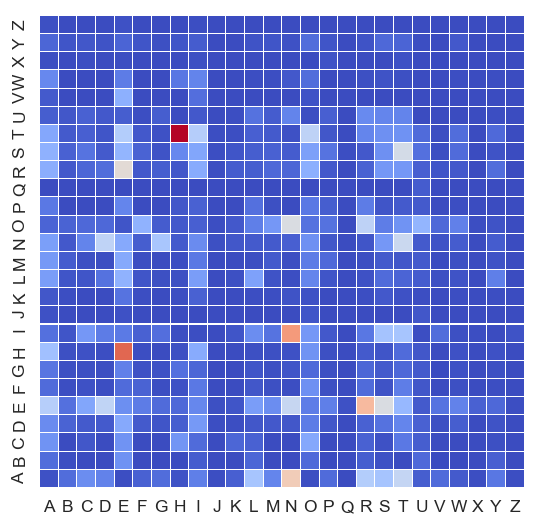

In [207]:
plt.figure(figsize=(5,5))
ax = sns.heatmap(english_incidence_matrix, cmap='coolwarm', cbar=False, linewidth=0.01) 
ax.invert_yaxis()
#ax = sns.clustermap(english_incidence_matrix, cmap='coolwarm', linewidth=0.01)

Number of exchanges as text length changes

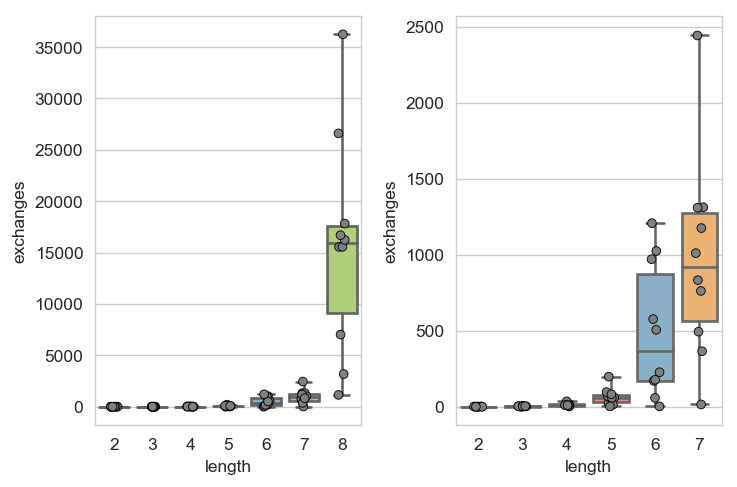

In [208]:
fig, ax = plt.subplots(1,2)
sns.stripplot(x='length', y='exchanges', data=results_single_prob, color='0.5', linewidth=0.5, edgecolor='black', ax=ax[0])
sns.boxplot(x='length', y='exchanges', data=results_single_prob, whis=np.inf, palette='Set3', ax=ax[0])
sns.stripplot(x='length', y='exchanges', data=results_single_prob_small, color='0.5', linewidth=0.5, edgecolor='black', ax=ax[1])
sns.boxplot(x='length', y='exchanges', data=results_single_prob_small, whis=np.inf, palette='Set3', ax=ax[1])
fig.tight_layout()
fig.show()

Number of exchanges as distance from typical changes

Number of exchanges as exchange probability changes